In [0]:
!wget https://datahack-prod.s3.amazonaws.com/train_file/train_6BJx641.csv
!wget https://datahack-prod.s3.amazonaws.com/test_file/test_pavJagI.csv

--2020-05-03 11:57:05--  https://datahack-prod.s3.amazonaws.com/train_file/train_6BJx641.csv
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.66.124
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.66.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1508468 (1.4M) [text/csv]
Saving to: ‘train_6BJx641.csv.1’

train_6BJx641.csv.1 100%[===================>]   1.44M   994KB/s    in 1.5s    

2020-05-03 11:57:07 (994 KB/s) - ‘train_6BJx641.csv.1’ saved [1508468/1508468]

--2020-05-03 11:57:09--  https://datahack-prod.s3.amazonaws.com/test_file/test_pavJagI.csv
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.62.28
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.62.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 437061 (427K) [text/csv]
Saving to: ‘test_pavJagI.csv.1’

test_pavJagI.csv.1  100%[

In [0]:
import numpy as np;
import pandas as pd;
import seaborn as sns;
import matplotlib.pyplot as plt;
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [0]:
train = pd.read_csv('train_6BJx641.csv')
test = pd.read_csv('test_pavJagI.csv')

In [0]:
train.head(5)

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,A,216.0
1,1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,A,210.0
2,2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,A,225.0
3,3,2013-07-01 03:00:00,-11.4,-17.1,995.0,582.580,A,216.0
4,4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,586.600,A,222.0


In [0]:
test.head(5)

,ID,datetime,temperature,var1,pressure,windspeed,var2
0,552,2013-07-24 00:00:00,-10.0,-16.4,1011.0,263.280,A
1,553,2013-07-24 01:00:00,-10.0,-20.7,1011.0,267.175,A
2,554,2013-07-24 02:00:00,-10.7,-17.1,1003.0,269.555,A
3,555,2013-07-24 03:00:00,-13.6,-20.7,1008.0,273.060,A
4,556,2013-07-24 04:00:00,-10.7,-17.1,1006.0,1.765,A


In [0]:
train.isnull().sum(),test.isnull().sum(),train.shape,test.shape

(ID                         0
 datetime                   0
 temperature                0
 var1                       0
 pressure                   0
 windspeed                  0
 var2                       0
 electricity_consumption    0
 dtype: int64, ID             0
 datetime       0
 temperature    0
 var1           0
 pressure       0
 windspeed      0
 var2           0
 dtype: int64, (26496, 8), (8568, 7))

In [0]:
train.dtypes,test.dtypes

(ID                           int64
 datetime                    object
 temperature                float64
 var1                       float64
 pressure                   float64
 windspeed                  float64
 var2                        object
 electricity_consumption    float64
 dtype: object, ID               int64
 datetime        object
 temperature    float64
 var1           float64
 pressure       float64
 windspeed      float64
 var2            object
 dtype: object)

In [0]:
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

In [0]:
train['var2'].nunique(),test['var2'].nunique()

(3, 3)

In [0]:
loc = np.append(train['var2'].values, test['var2'].values, axis=0)
from sklearn.preprocessing import LabelEncoder
l=LabelEncoder()
l.fit(list(set(loc)))
train['var2']=l.transform(train['var2'])
test['var2']=l.transform(test['var2'])

In [0]:
train['year'] = train['datetime'].dt.year
train['day'] = train['datetime'].dt.day
train['weekofyear'] = train['datetime'].dt.weekofyear
train['month'] = train['datetime'].dt.month
train['dayofweek'] = train['datetime'].dt.dayofweek
train['weekend'] = (train['datetime'].dt.weekday >=5).astype(int)
#df['days_since_release'] = (datetime.datetime(2019, 8, 1) - df['Timestamp']).dt.days
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute

In [0]:
test['year'] = test['datetime'].dt.year
test['day'] = test['datetime'].dt.day
test['weekofyear'] = test['datetime'].dt.weekofyear
test['month'] = test['datetime'].dt.month
test['dayofweek'] = test['datetime'].dt.dayofweek
test['weekend'] = (test['datetime'].dt.weekday >=5).astype(int)
#df['days_since_release'] = (datetime.datetime(2019, 8, 1) - df['Timestamp']).dt.days
test['hour'] = test['datetime'].dt.hour
test['minute'] = test['datetime'].dt.minute

In [0]:
del train['datetime']
del test['datetime']

In [0]:
train_df=train

In [0]:
scaler = MinMaxScaler()
scaler.fit(train.drop(['electricity_consumption', 'ID'], axis = 1))
train_n = scaler.transform(train.drop(['electricity_consumption', 'ID'], axis = 1))

In [0]:
scaler = MinMaxScaler()
scaler.fit(test.drop(['ID'], axis = 1))
test_n = scaler.transform(test.drop(['ID'], axis = 1))

In [0]:
train_n = np.array(train_n)
train_norm = pd.DataFrame(train_n, columns=train.columns.drop(['electricity_consumption', 'ID']))

In [0]:
test_n = np.array(test_n)
test_norm = pd.DataFrame(test_n, columns=test.columns.drop(['ID']))

In [0]:
train.columns

Index(['ID', 'temperature', 'var1', 'pressure', 'windspeed', 'var2',
       'electricity_consumption', 'year', 'day', 'weekofyear', 'month',
       'dayofweek', 'weekend', 'hour', 'minute'],
      dtype='object')

In [0]:
train_norm_merge = train_norm
train_norm_merge['electricity_consumption'] = train['electricity_consumption']
train_norm_merge.head()

,temperature,var1,pressure,windspeed,var2,year,day,weekofyear,month,dayofweek,weekend,hour,minute,electricity_consumption
0,0.140049,0.306796,0.704225,0.974911,0.0,0.0,0.0,0.5,0.545455,0.0,0.0,0.000000,0.0,216.0
1,0.122850,0.264078,0.605634,0.980257,0.0,0.0,0.0,0.5,0.545455,0.0,0.0,0.043478,0.0,210.0
2,0.103194,0.250485,0.661972,0.986055,0.0,0.0,0.0,0.5,0.545455,0.0,0.0,0.086957,0.0,225.0
3,0.140049,0.306796,0.591549,0.993134,0.0,0.0,0.0,0.5,0.545455,0.0,0.0,0.130435,0.0,216.0
4,0.140049,0.264078,0.732394,1.000000,0.0,0.0,0.0,0.5,0.545455,0.0,0.0,0.173913,0.0,222.0


In [0]:
train_df = train_norm_merge
test_df = test_norm

In [0]:
test_norm.head(5)

,temperature,var1,pressure,windspeed,var2,year,day,weekofyear,month,dayofweek,weekend,hour,minute
0,0.181193,0.225734,0.826087,0.534916,0.0,0.0,0.0,0.557692,0.545455,0.333333,0.0,0.000000,0.0
1,0.181193,0.128668,0.826087,0.542862,0.0,0.0,0.0,0.557692,0.545455,0.333333,0.0,0.043478,0.0
2,0.165138,0.209932,0.710145,0.547717,0.0,0.0,0.0,0.557692,0.545455,0.333333,0.0,0.086957,0.0
3,0.098624,0.128668,0.782609,0.554868,0.0,0.0,0.0,0.557692,0.545455,0.333333,0.0,0.130435,0.0
4,0.165138,0.209932,0.753623,0.001408,0.0,0.0,0.0,0.557692,0.545455,0.333333,0.0,0.173913,0.0


In [0]:
X = train_df.drop(labels=['electricity_consumption'], axis=1)
y = train_df['electricity_consumption'].values

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=42)

In [0]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((19872, 13), (19872,), (6624, 13), (6624,))

In [0]:

from math import sqrt 
from sklearn.metrics import mean_squared_log_error

In [0]:

import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_cv, label=y_cv)

param = {'objective': 'regression',
         'boosting': 'gbdt',  
         'metric': 'l2_root',
         'learning_rate': 0.01, 
         'num_iterations': 3500,
         'num_leaves': 80,
         'max_depth': -1,
         'min_data_in_leaf': 11,
         'bagging_fraction': 0.80,
         'bagging_freq': 1,
         'bagging_seed': 3,
         'feature_fraction': 0.80,
         'feature_fraction_seed': 2,
         'early_stopping_round': 200,
         'max_bin': 250
         }

lgbm = lgb.train(params=param, verbose_eval=100, train_set=train_data, valid_sets=[test_data])

y_pred_lgbm = lgbm.predict(X_cv)
print('RMSLE:', sqrt(mean_squared_log_error(y_cv,y_pred_lgbm)))

Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmse: 78.6757
[200]	valid_0's rmse: 68.2608
[300]	valid_0's rmse: 62.5774
[400]	valid_0's rmse: 59.3477
[500]	valid_0's rmse: 57.2179
[600]	valid_0's rmse: 55.9639
[700]	valid_0's rmse: 54.9955
[800]	valid_0's rmse: 54.2059
[900]	valid_0's rmse: 53.5363
[1000]	valid_0's rmse: 52.9625
[1100]	valid_0's rmse: 52.4284
[1200]	valid_0's rmse: 51.9827
[1300]	valid_0's rmse: 51.5493
[1400]	valid_0's rmse: 51.1731
[1500]	valid_0's rmse: 50.8412
[1600]	valid_0's rmse: 50.6189
[1700]	valid_0's rmse: 50.4189
[1800]	valid_0's rmse: 50.1934
[1900]	valid_0's rmse: 50.0054
[2000]	valid_0's rmse: 49.7859
[2100]	valid_0's rmse: 49.6033
[2200]	valid_0's rmse: 49.4477
[2300]	valid_0's rmse: 49.3013
[2400]	valid_0's rmse: 49.1652
[2500]	valid_0's rmse: 49.0319
[2600]	valid_0's rmse: 48.8768
[2700]	valid_0's rmse: 48.7592
[2800]	valid_0's rmse: 48.6478
[2900]	valid_0's rmse: 48.5319
[3000]	valid_0's rmse: 48.4247
[3100]	valid_0's

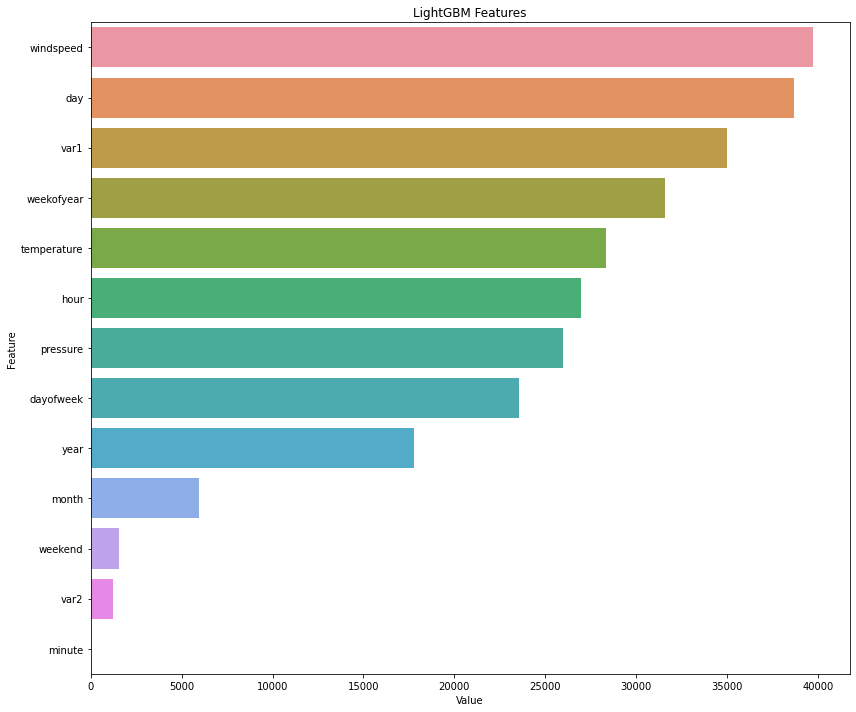

In [0]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importance(), X.columns), reverse=True)[:50], 
                           columns=['Value','Feature'])
plt.figure(figsize=(12, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [0]:
Xtest = test_df

In [0]:
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor

errlgb = []
y_pred_totlgb = []

fold = KFold(n_splits=15, shuffle=True, random_state=42)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lgbm = LGBMRegressor(boosting_type='gbdt', num_leaves=500, max_depth=31, learning_rate=0.1, n_estimators=1000, min_child_samples=20, subsample=0.80)
    lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=200)

    y_pred_lgbm = lgbm.predict(X_test)
    print("RMSLE LGBM: ", sqrt(mean_squared_log_error(y_test,y_pred_lgbm)))

    errlgb.append(sqrt(mean_squared_log_error(y_test,y_pred_lgbm)))
    p = lgbm.predict(Xtest)
    y_pred_totlgb.append(p)

RMSLE LGBM:  0.13723773368911338
RMSLE LGBM:  0.13561444688471141
RMSLE LGBM:  0.13390461761247735
RMSLE LGBM:  0.14281633706141625
RMSLE LGBM:  0.1362829190181764
RMSLE LGBM:  0.13590592735855622
RMSLE LGBM:  0.12951795024059562
RMSLE LGBM:  0.13678352040557812
RMSLE LGBM:  0.1353621138503754
RMSLE LGBM:  0.13735412231289956
RMSLE LGBM:  0.13829277351432065
RMSLE LGBM:  0.14020597599757628
RMSLE LGBM:  0.13950575414402774
RMSLE LGBM:  0.13937531819479787
RMSLE LGBM:  0.1383929743335136


In [0]:
np.mean(errlgb,0)

0.13710349897454235

In [0]:
lgbm_final = np.mean(y_pred_totlgb,0)
lgbm_final

array([237.52123783, 221.2507231 , 226.95120752, ..., 197.5045491 ,
       192.88414336, 194.77972281])

In [0]:
submission = pd.DataFrame({
        "ID": test['ID'],
        "electricity_consumption": lgbm_final
    })
submission.to_csv('./submission.csv', index=False)
print(submission)

         ID  electricity_consumption
0       552               237.521238
1       553               221.250723
2       554               226.951208
3       555               189.012410
4       556               210.842002
...     ...                      ...
8563  35059               192.552703
8564  35060               195.764110
8565  35061               197.504549
8566  35062               192.884143
8567  35063               194.779723

[8568 rows x 2 columns]


In [0]:
from google.colab import files
files.download('submission.csv')

In [0]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(verbose=1, learning_rate=0.1, n_estimators=100, random_state=101, subsample=0.8, loss='ls')
gb.fit(X_train, y_train)
y_pred = gb.predict(X_cv)
print('score', 100-sqrt(mean_absolute_error(y_cv, y_pred)))

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       11035.0395         437.4274            3.40s
         2       10810.3011         373.6080            3.19s
         3       10678.4829         302.0507            3.08s
         4       10291.7298         294.7273            2.98s
         5       10042.4170         221.4797            2.91s
         6        9760.7905         203.4776            2.84s
         7        9725.3900         177.5437            2.84s
         8        9522.8391         161.0409            2.80s
         9        9171.9079         134.5730            2.76s
        10        9313.5340          92.0441            2.71s
        20        8479.1077          89.2778            2.36s
        30        7848.6253          86.9273            2.05s
        40        7308.9126          43.3386            1.74s
        50        6954.5831          12.1183            1.45s
        60        6554.1176          31.7992            1.16s
       

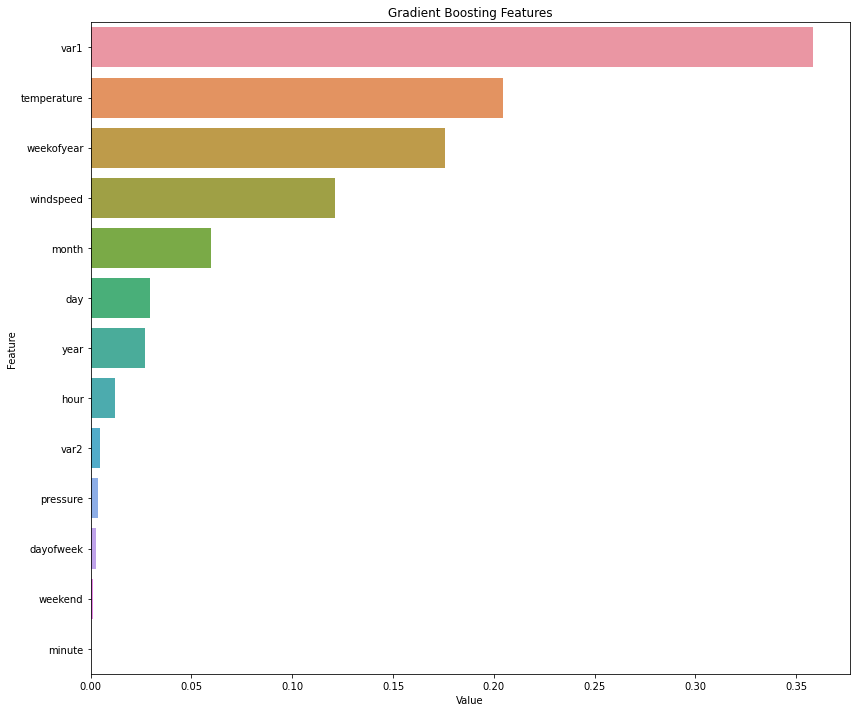

In [0]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(gb.feature_importances_, X.columns), reverse=True)[:60], columns=['Value','Feature'])
plt.figure(figsize=(12,10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Gradient Boosting Features')
plt.tight_layout()
plt.show()

In [0]:
!pip install pmdarima
!pip install dateparser
from sklearn.model_selection import train_test_split
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

from statsmodels.tsa.arima_model import ARIMA

import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import statsmodels.api as sm

import dateparser

     |████████████████████████████████| 358kB 4.7MB/s 


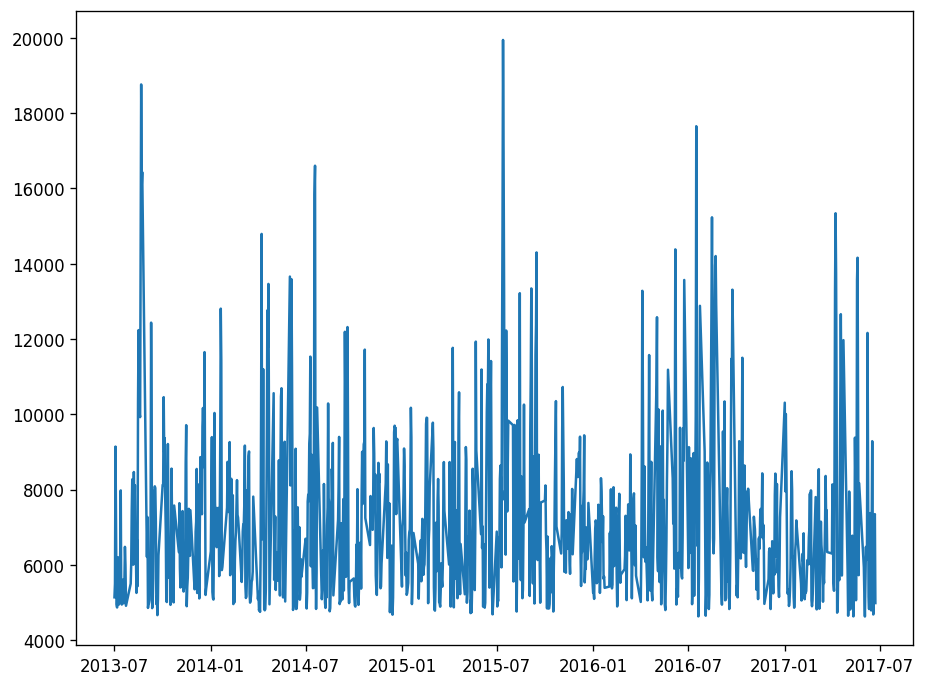

In [0]:
df=train
df['datetime'] = pd.to_datetime(df['datetime'],format = '%Y-%m-%d %H:%M:%S')
df['date'] = df['datetime'].dt.date
df = df.groupby(['date'])['electricity_consumption'].sum().reset_index()
df = df.set_index('date')

plt.plot(df.index, df.electricity_consumption)

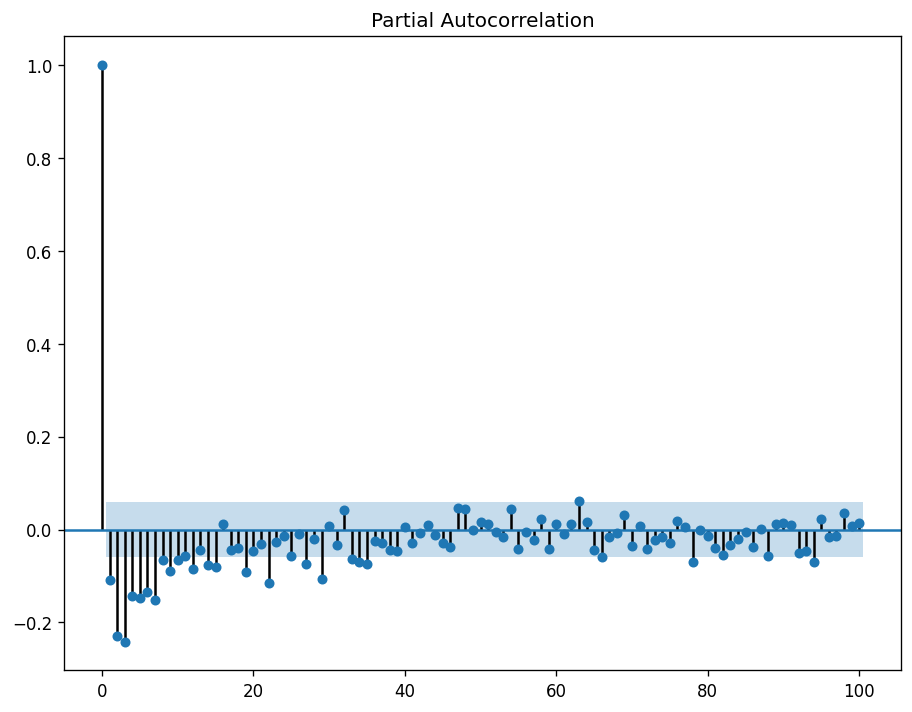

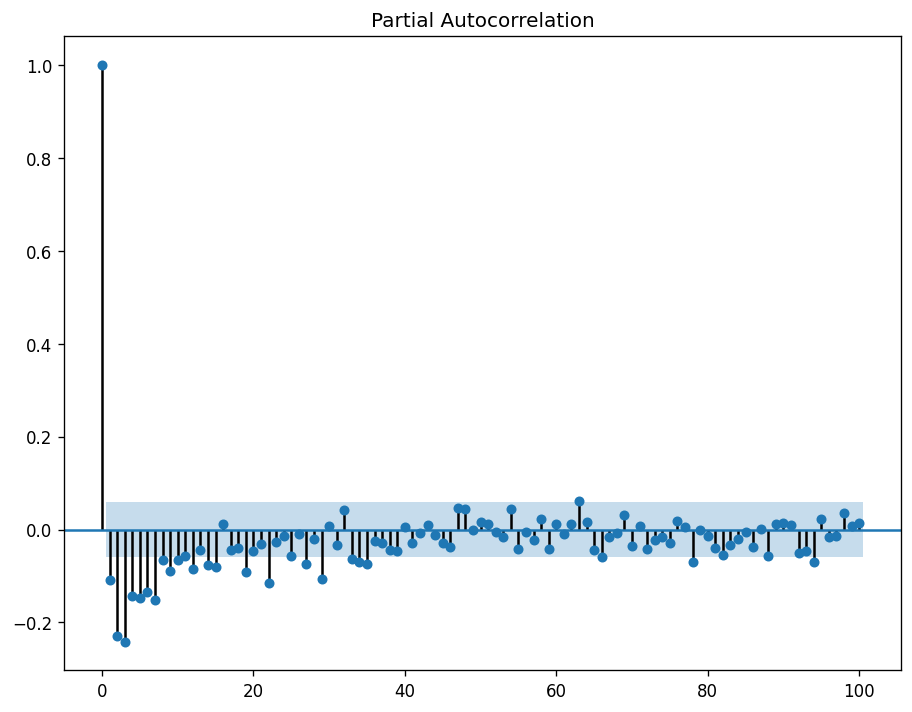

In [0]:

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
plot_pacf(df.electricity_consumption.diff().dropna(), lags = 100)

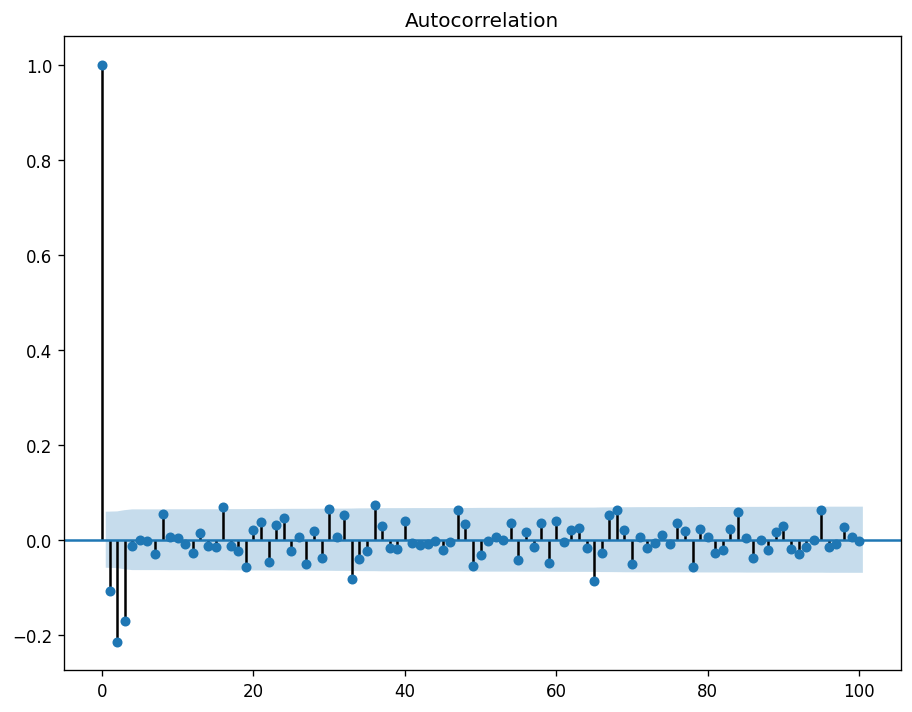

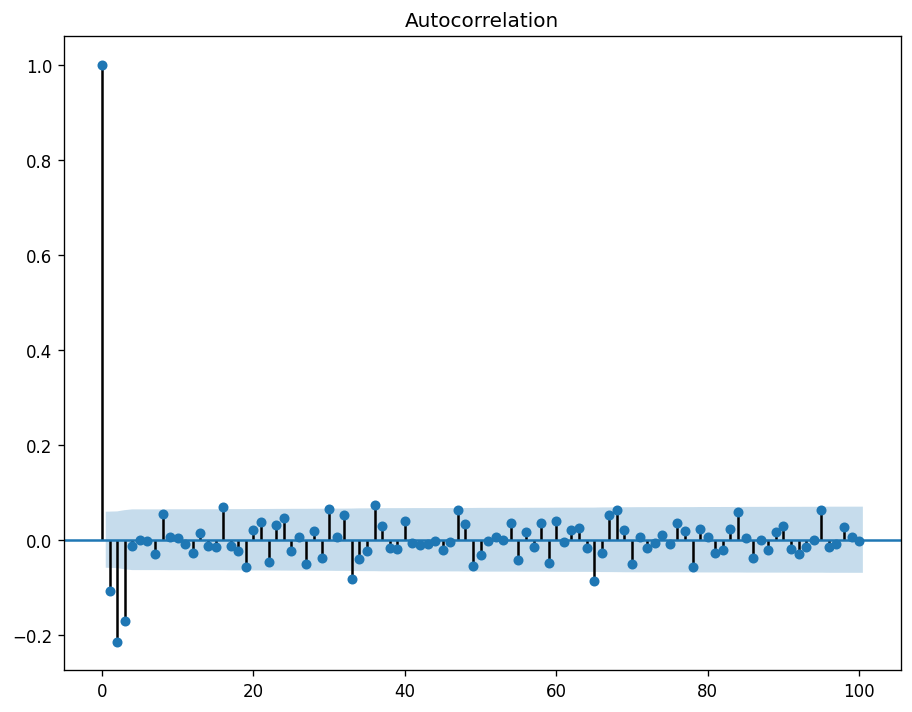

In [0]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
plot_acf(df.electricity_consumption.diff().dropna(), lags = 100)

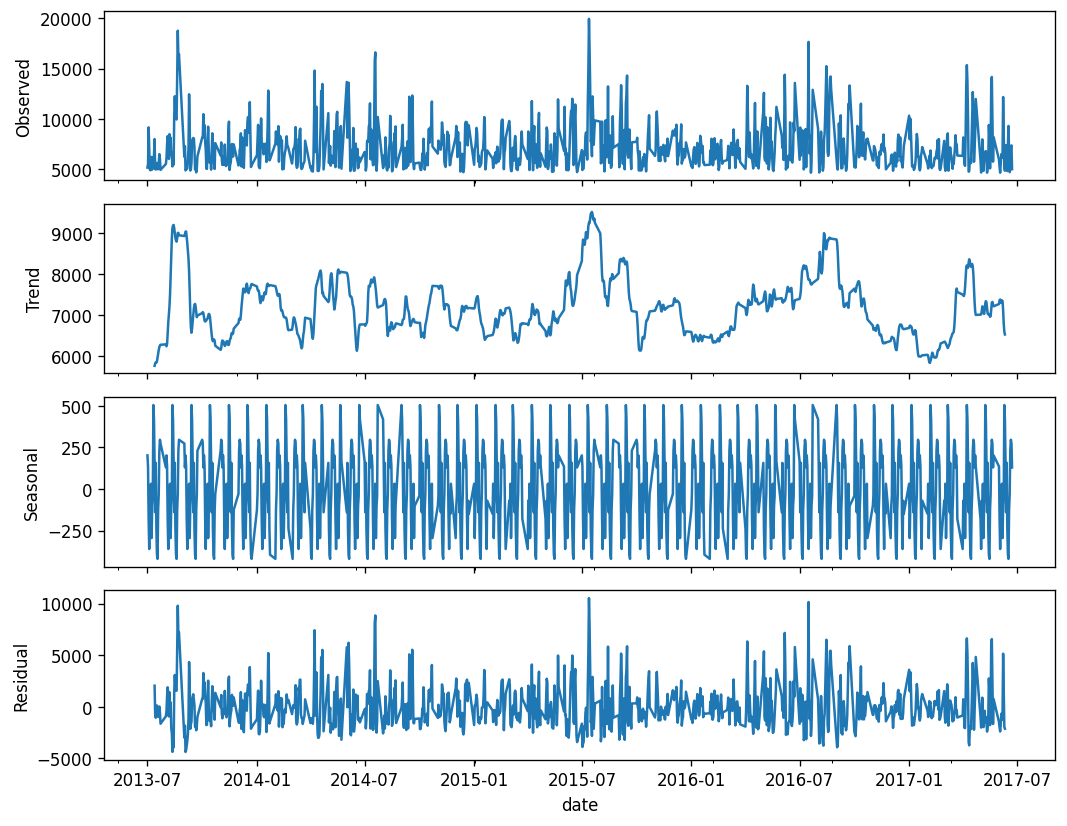

In [0]:
sm.tsa.seasonal_decompose(df.electricity_consumption, freq=24).plot()
result = sm.tsa.stattools.adfuller(df.electricity_consumption)
plt.show()

In [0]:
train_df = df[:]

mod = sm.tsa.statespace.SARIMAX(train_df.electricity_consumption, order=(5,1,2), seasonal_order=(1,1,1,7))
results = mod.fit()
print(results.summary())

a_preds = results.predict(start = 762, end= 974, dynamic= True)
preds_old = results.predict(start = 0, end= 761, dynamic= False)
print(a_preds.sum())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                
Dep. Variable:           electricity_consumption   No. Observations:                 1104
Model:             SARIMAX(5, 1, 2)x(1, 1, 1, 7)   Log Likelihood               -9966.581
Date:                           Sat, 02 May 2020   AIC                          19953.163
Time:                                   11:52:57   BIC                          20003.157
Sample:                                        0   HQIC                         19972.079
                                          - 1104                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1428      0.778      0.184      0.854      -1.382       1.667
ar.L2         -0.1184      0.462     -0.257

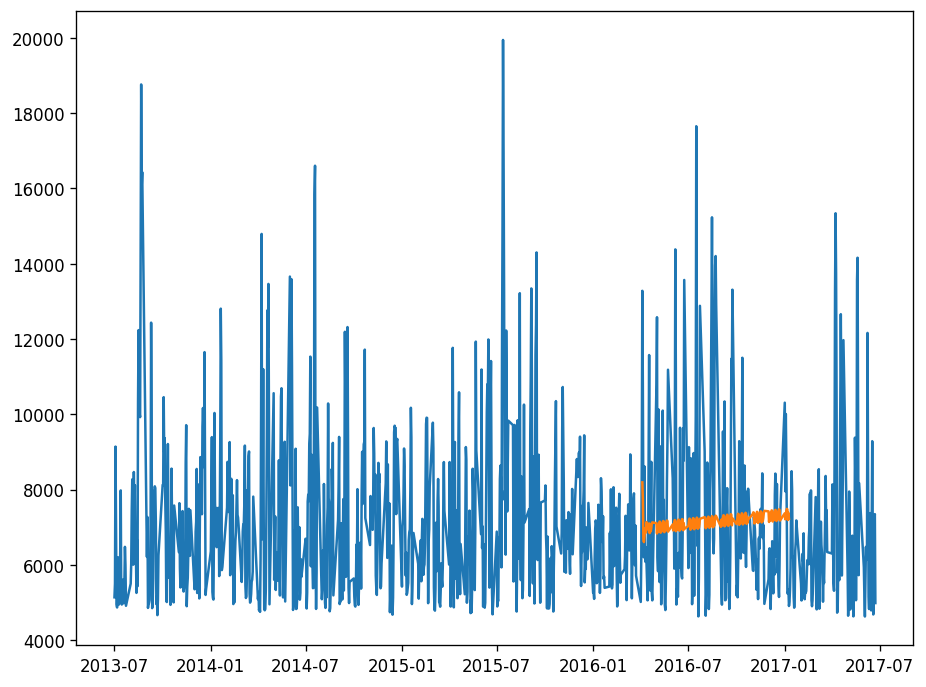

In [0]:
plt.plot(df.index, df.electricity_consumption)
plt.plot(a_preds.index, a_preds)